In [1]:
import cell2cell as c2c
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlp
from mpl_toolkits.mplot3d import Axes3D

import skbio, scipy

%matplotlib inline

# Analysis Setup

Here, all inputs and parameters needed for the analysis are defined

**Location of files**

In [2]:
C2C_ROOT = '/Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell/'

**<font color=red>When using other organism, it is important to have the same gene IDs or names in all the data sources. *That is, rnaseq, ppi and go_annotations*.</font>**

In [3]:
files = dict()
files['rnaseq'] = C2C_ROOT + '/data/CElegans_RNASeqData_Cell.xlsx'
files['ppi'] = C2C_ROOT + '/data/CElegans_PPIs_STRING.txt.gz' # This could be replaced by other PPI network.
files['go_annotations'] = C2C_ROOT + '/data/wb.gaf.gz' # For human dataset, this link could be provided directly: http://geneontology.org/gene-associations/goa_human.gaf.gz
files['go_terms'] = C2C_ROOT + '/data/go-basic.obo'
files['output_folder'] = '../outputs/'

**RNA-seq data manipulation**

- <font color="green">'gene_col'</font> is the name of the column containing the list or names of genes in the dataset.
- <font color="green">'drop_nangenes'</font> is a boolean decision to remove those genes with NaN values.
- <font color="green">'log_transform'</font> is a boolean decision to log-transform the dataset.

In [4]:
rnaseq_setup = dict()
rnaseq_setup['gene_col'] = 'gene_id'
rnaseq_setup['drop_nangenes'] = True
rnaseq_setup['log_transform'] = True

**Columns for PPI network**

- <font color="green">'protein_cols'</font> is a list containing the names of the first and second interactors.

In [5]:
ppi_setup = dict()
ppi_setup['protein_cols'] = ['protein1', 'protein2']

**Cutoffs setup for binarizing gene expression**

- <font color="green">'type'</font> is the type of cutoff to use. So far, only 'local_percentile' and 'global_percentile' are implemented. Local percentile is used to compute the cutoff locally, gene by gene; while a global percentiles is calculated from the entire dataset.
- <font color="green">'parameter'</font> is the corresponding parameter for the type of cutoff. If percentile is used, it should be a value between 0 and 1. E.g. a value of 0.75 represents the 75-th percentile, and the cutoff to binarize the gene expression will be that value.

In [6]:
cutoff_setup = dict()
cutoff_setup['type'] = 'local_percentile'
cutoff_setup['parameter'] = 0.75

**GO annotation and terms to filter PPI network**

- <font color="green">'experimental_evidence'</font> is a boolean decision to consider only GO annotations of genes that have experimental support (e.g. associated articles).
- <font color="green">'descendants'</font> is a boolean decision to consider the GO terms that are children of a given GO term (based on their hierarchy).

In [7]:
go_setup = dict()
go_setup['experimental_evidence'] = False
go_setup['descendants'] = True

**General Analysis setups**

- <font color="green">'interaction_type'</font> is the type of intercellular interaction to analyze. It could be 'contacts', 'mediated', or 'combined'. The last one considers 'contacts' and 'mediated' together.
- <font color="green">'score_type'</font> is the type of score to calculate the interaction index for a pair of cells. It could be 'binary' to use 0 or 1 values of gene expression depending on a cutoff value for each one or 'weighted' to use a continue value between 0 and 1 given the maximal expression level of each gene.
- <font color="green">'score_metric'</font> is the metric approach to compute the score. Current options are 'bray_curtis' and 'jaccard'.
- <font color="green">'subsampling_space'</font> is the ratio of cells to be randomly considered in each iteration to compute the interactions. Here, iterations are used especially when using percentile cutoff, to avoid enrichment for cell types with high expression levels of certain genes.
- <font color="green">'iterations'</font> is the number of iterations to perform different random subsamplings.
- <font color="green">'cpu_cores'</font> is the number of cores to use and run parallelly the iterations for subsampling.

In [8]:
analysis_setup = dict()
analysis_setup['interaction_type'] = ['contacts', 'mediated', 'combined', 'complete']
analysis_setup['score_type'] = 'binary'
analysis_setup['score_metric'] = 'bray_curtis'
analysis_setup['subsampling_percentage'] = 1.0
analysis_setup['iterations'] = 1
analysis_setup['cpu_cores'] = 1 # To enable parallel computing when 'iterations' is greater than 1.

# Load Data

**RNA-seq**

In [9]:
rnaseq_data = c2c.io.load_rnaseq(rnaseq_file=files['rnaseq'],
                                 gene_column=rnaseq_setup['gene_col'],
                                 drop_nangenes=rnaseq_setup['drop_nangenes'],
                                 log_transformation=rnaseq_setup['log_transform'],
                                 format='auto')

Opening RNAseq datasets from /Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell//data/CElegans_RNASeqData_Cell.xlsx
/Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell//data/CElegans_RNASeqData_Cell.xlsx was correctly loaded


**PPI network**

In [10]:
ppi_data = c2c.io.load_ppi(ppi_file=files['ppi'],
                           interaction_columns=ppi_setup['protein_cols'],
                           rnaseq_genes=list(rnaseq_data.index),
                           format='auto')

Opening PPI datasets from /Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell//data/CElegans_PPIs_STRING.txt.gz
/Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell//data/CElegans_PPIs_STRING.txt.gz was correctly loaded
Removing bidirectionality of PPI network
Simplying PPI network


**GO annotations and GO terms**

In [11]:
go_annotations = c2c.io.load_go_annotations(goa_file=files['go_annotations'],
                                            experimental_evidence=go_setup['experimental_evidence'])

go_terms = c2c.io.load_go_terms(go_terms_file=files['go_terms'])

Opening GO annotations from /Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell//data/wb.gaf.gz


/Users/earmingol/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (9,15) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


/Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell//data/wb.gaf.gz was correctly loaded
Opening GO terms from /Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell//data/go-basic.obo
/Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell//data/go-basic.obo was correctly loaded


**Metadata for cell types**

In [12]:
meta = c2c.io.load_table(C2C_ROOT + '/data/CElegans_cell_metadata.tsv', format='auto')
meta.index = [str(i) for i, c in enumerate(rnaseq_data.columns)]

/Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell//data/CElegans_cell_metadata.tsv was correctly loaded


# Run Analysis

**Obtain PPI networks for all types of interactions (contact, mediated and combined interactions)**

This generates a dictionary containing PPI networks for each interaction type. The PPI networks are filtered with the respective GO terms.

The default GO terms used for the heuristic approach are contained in an instance of c2c.datasets.HeuristicGO. For contact proteins (those on cell surface) use <font color="blue">*c2c.datasets.HeuristicGO.contact_go_terms*</font> and for secreted or extracellular proteins use <font color="blue">*c2c.datasets.HeuristicGO.mediator_go_terms*</font>. Specific GO terms that include certain keyword using the function <font color="blue">*c2c.preprocessing.find_go_terms_from_keyword(go_term, 'keyword')*</font>.

Additionally, instead of finding genes heuristically from GO terms, we can provide a manually curated list of genes/proteins in *contact_proteins* and *mediator_proteins*. Then, those loaded lists could be directly passed to <font color="blue">*c2c.preprocessing.get_ppi_dict_from_proteins(ppi_data, contact_proteins, mediator_proteins)*</font>.

**Generate list of genes associated to cell contacts**

In [13]:
default_go_terms = c2c.datasets.HeuristicGO()

In [14]:
contact_genes = c2c.preprocessing.get_genes_from_go_hierarchy(go_annotations,
                                                              go_terms,
                                                              default_go_terms.contact_go_terms) 
contact_genes = list(set(contact_genes))

Filtering genes by using GO terms


In [15]:
len(contact_genes)

1051

**Generate list of genes associated to secreted and mediator proteins of cells**

In [16]:
mediator_genes = c2c.preprocessing.get_genes_from_go_hierarchy(go_annotations,
                                                               go_terms,
                                                               default_go_terms.mediator_go_terms)
mediator_genes = list(set(mediator_genes))

Filtering genes by using GO terms


In [17]:
len(mediator_genes)

577

**Generate PPIs for all interaction types**

In [18]:
ppi_dict = c2c.preprocessing.get_ppi_dict_from_proteins(ppi_data,
                                                        contact_genes,
                                                        mediator_genes,
                                                        verbose=False
                                                        )

In [19]:
for interaction, ppi in ppi_dict.items():
    print('{} has {} PPIs'.format(interaction, len(ppi)))

contacts has 42256 PPIs
mediated has 21826 PPIs
combined has 61686 PPIs
complete has 76556 PPIs


**Compute CCI values for each random subsampling round**

In [20]:
subsampling_space = dict()
distance_cci = dict()
for interaction in analysis_setup['interaction_type']:
    print('Running analysis for ' + interaction)
    subsampling_space[interaction] = c2c.core.SubsamplingSpace(rnaseq_data=rnaseq_data,
                                                               ppi_dict=ppi_dict,
                                                               interaction_type=interaction,
                                                               gene_cutoffs=cutoff_setup,
                                                               score_type=analysis_setup['score_type'],
                                                               score_metric=analysis_setup['score_metric'],
                                                               subsampling_percentage=analysis_setup['subsampling_percentage'],
                                                               iterations=analysis_setup['iterations'],
                                                               n_jobs=analysis_setup['cpu_cores'],
                                                               initial_seed=0, # Random seed to compare results and conditions
                                                               verbose=False)
    
    # Since the CCI matrix can be considered as a similarity matrix, 
    # we can compute pseudo-distances between cells, then cluster them.
    distance_cci[interaction] = subsampling_space[interaction].average_cci_matrix.apply(lambda x: 1-x)
    
    #Remove self distances
    np.fill_diagonal(distance_cci[interaction].values, 0.0)

Running analysis for contacts
Running analysis for mediated
Running analysis for combined
Running analysis for complete


# Clustering

**Row colors**

In [22]:
meta_ = meta.set_index('#SampleID')
labels = list(meta_.Groups)
#lut = dict(zip(set(labels), sns.mpl_palette("Set1", len(set(labels)))))

# Colors from figure S14 in C elegans paper (cell type expression data)
lut = {'Coelomocytes': (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), # Brown
       'Neurons': (0.596078431372549, 0.3058823529411765, 0.6392156862745098), # Purple
       'Hypodermic/rectal cells': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), # Green
       'Pharyngeal cells': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), # Blue
       'Intestine': (1.0, 1.0, 0.2), # Yellow
       'Body/muscular cells': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), # Red
       'Excretory/Socket/Sheath cells': (1.0, 0.4980392156862745, 0.0), # Orange
       'Sexual cells': (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)} # Pink

row_colors = pd.DataFrame(labels)[0].map(lut)
row_colors.index = meta_.index
row_colors.name = 'CELL GROUP'

**Hierarchical Clustering on Average CCI matrices**

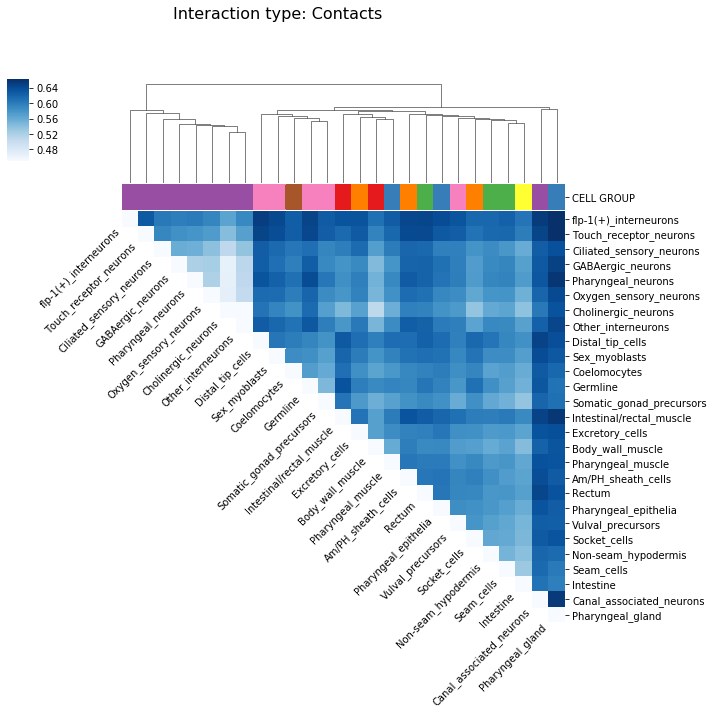

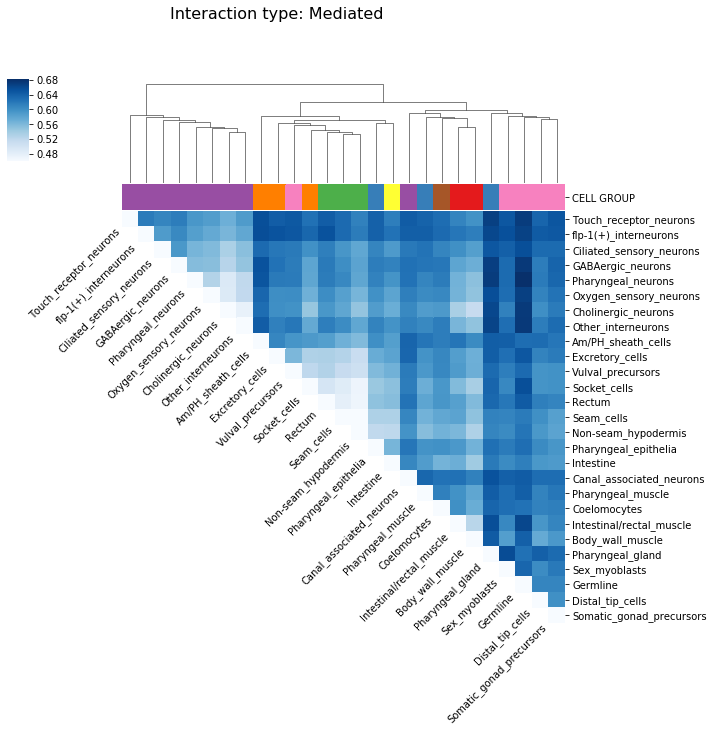

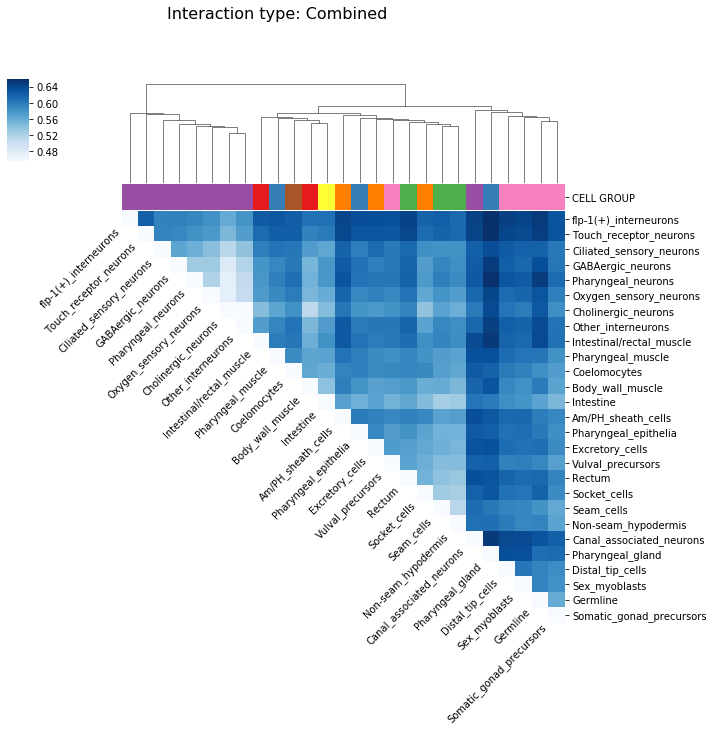

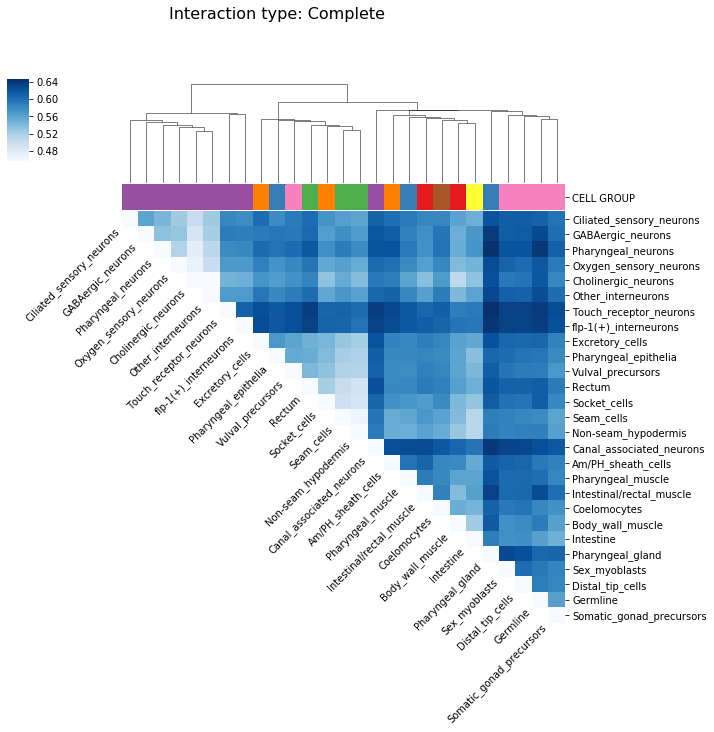

In [24]:
for interaction, distance_matrix in distance_cci.items():  
    c2c.utils.hierarchical_clustering(distance_matrix,
                                      method='ward',
                                      title='Interaction type: ' + interaction.capitalize(),
                                      filename='../outputs/CElegans-CCI-Bin-{}-Clustering.png'.format(interaction.capitalize()),
                                      **{'col_colors' : row_colors,
                                      'cmap' : 'Blues'}
                                      )

# PCoA

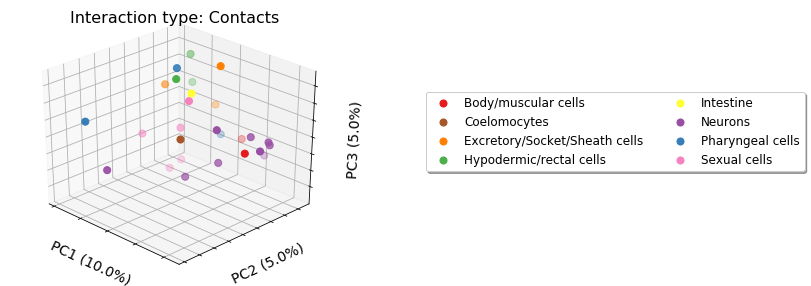

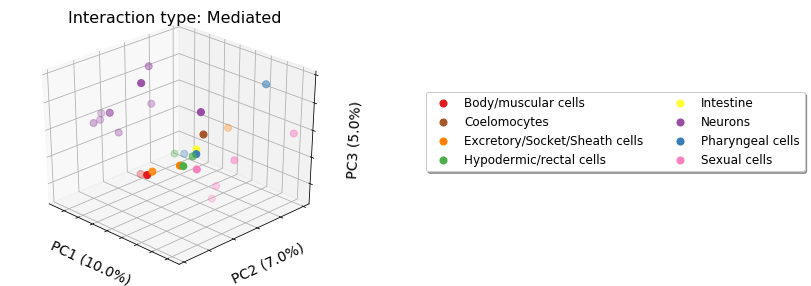

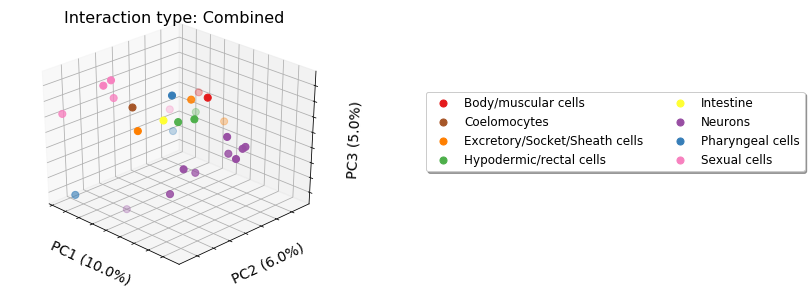

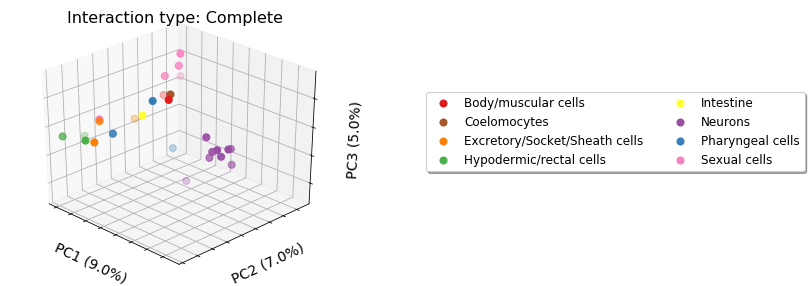

In [27]:
pcoa = dict()
for interaction, distance_matrix in distance_cci.items():
    pcoa[interaction] = c2c.utils.pcoa_biplot(distance_matrix,
                                              meta,
                                              sample_col='#SampleID',
                                              group_col='Groups',
                                              colors=lut,
                                              title='Interaction type: ' + interaction.capitalize(),
                                              filename='../outputs/CElegans-CCI-Bin-{}-PCoA.png'.format(interaction.capitalize())
                                              )